# Musical instruments prices
### A study of the musical instruments market in Sri Lanka

Author: Leandro Hornos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import json

from wordcloud import WordCloud

In [2]:
df = pd.read_csv("raw-data.csv", encoding="utf-8", parse_dates=["published_date"])

## Cleaning the dataset

Let's take a look at data that we imported from the csv

In [3]:
df.head(3)

,Title,Sub_title,Price,Instrument_Type,Condition,Location,Description,Post_URL,Seller_name,Seller_type,published_date
0,Yamaha (SY-77) Music Synthesizer for sale,"Posted on 04 Oct 7:11 pm, Ja-Ela, Gampaha","Rs 39,000",Keyboard / Piano,Used,"Ja-Ela, Gampaha",Â°â¢Â°Sri Lanka's Largest Digital Piano Selle...,https://ikman.lk/en/ad/yamaha-sy-77-music-synt...,Seven Star International,Member,2021-10-04 19:11:00
1,SRX-718 BASS BIN (PAIR) for sale,"Posted on 10 Oct 7:54 pm, Kadawatha, Gampaha","Rs 77,500",Studio / Live Music Equipment,New,"Kadawatha, Gampaha",â¡Watts 3200â¡â¡Treated Plywoodâ¡,https://ikman.lk/en/ad/srx-718-bass-bin-pair-f...,Sasiru Super Sonics,Member,2021-10-10 19:54:00
2,Piano (Malcom Mendis Piano) for sale,"Posted on 13 Oct 12:43 pm, Kandana, Gampaha","Rs 130,000",Keyboard / Piano,Used,"Kandana, Gampaha","Sri Lanka's Biggest Piano Sale, Reasonable pri...",https://ikman.lk/en/ad/piano-malcom-mendis-pia...,Sell Fast | à¶à¶³à·à¶± | MCI Ikman à¶¯à·à¶±...,Member,2021-10-13 12:43:00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5167 entries, 0 to 5166
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Title            5167 non-null   object        
 1   Sub_title        5167 non-null   object        
 2   Price            5167 non-null   object        
 3   Instrument_Type  5167 non-null   object        
 4   Condition        5167 non-null   object        
 5   Location         5167 non-null   object        
 6   Description      5167 non-null   object        
 7   Post_URL         5167 non-null   object        
 8   Seller_name      5167 non-null   object        
 9   Seller_type      5167 non-null   object        
 10  published_date   5167 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(10)
memory usage: 444.2+ KB


We can se that we have no missing values on this dataset. 

In [5]:
print(df.Condition.unique())
print(df.Seller_type.unique())

['Used' 'New']
['Member' 'Premium-Member']


As suspected, both variables are binaries. We will change those of a new pair of variables that take 1s and 0s as it's possible values

**Text fields**<br>
We can see that text fields are filled with strange characters. # If we take a look at the "Description" column, we will see some weird characters mixed with the text

In [6]:
df[["Title", "Description"]].head()

,Title,Description
0,Yamaha (SY-77) Music Synthesizer for sale,Â°â¢Â°Sri Lanka's Largest Digital Piano Selle...
1,SRX-718 BASS BIN (PAIR) for sale,â¡Watts 3200â¡â¡Treated Plywoodâ¡
2,Piano (Malcom Mendis Piano) for sale,"Sri Lanka's Biggest Piano Sale, Reasonable pri..."
3,Yamaha Semi Acoustic Guitars for sale,Yamaha semi acoustic guitar. Model- FX310A. B...
4,Yamaha Guitar for sale,Yamaha fG-151 Made in Japan Good condition Goo...


In [7]:
# We define a function to remove every non ascii character

def removeNonAsciiChars(text):
    return "".join(char for char in text if ord(char) <128)
    
df["Description"] = df["Description"].apply(removeNonAsciiChars)
df["Title"] = df["Title"].apply(removeNonAsciiChars)
df[["Title", "Description"]].head()

,Title,Description
0,Yamaha (SY-77) Music Synthesizer for sale,Sri Lanka's Largest Digital Piano Seller Dire...
1,SRX-718 BASS BIN (PAIR) for sale,Watts 3200Treated Plywood
2,Piano (Malcom Mendis Piano) for sale,"Sri Lanka's Biggest Piano Sale, Reasonable pri..."
3,Yamaha Semi Acoustic Guitars for sale,Yamaha semi acoustic guitar. Model- FX310A. B...
4,Yamaha Guitar for sale,Yamaha fG-151 Made in Japan Good condition Goo...


Everything looks fine, but whe see the irrelevan phrase "for sale" in most of the titles. We are going to remove it before going on.

In [8]:
df["Title"] = df["Title"].apply(lambda x: x.replace(" for sale", ""))

# Check that the substring is gone
df["Title"].iloc[:10]

0    Yamaha (SY-77) Music Synthesizer
1             SRX-718 BASS BIN (PAIR)
2         Piano (Malcom Mendis Piano)
3        Yamaha Semi Acoustic Guitars
4                       Yamaha Guitar
5                              Violin
6        Expnsoin Card Xp 30.50.60.80
7                                    
8            semi acoustic box guitar
9           32 keys Melodica full set
Name: Title, dtype: object

Now we have to check again for empty strings in the Title and Description fields, because some of those fields may have had only non ascii characters and now they are empty

In [9]:
print(df[df["Title"] == "" ].shape[0], "titles are empty")
print(df[df["Description"] == "" ].shape[0],"descrpitions are empty")

17 titles are empty
0 descrpitions are empty


There are no empty descriptions but some of them contain only one o more ascii characters that passed the filter but it is not usefull information. We are going to delete the rows that have no info in the title, since we want to extract info from that field

In [10]:
df = df[df["Title"] != "" ]

In [11]:
df[["Title","Description"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5150 entries, 0 to 5166
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        5150 non-null   object
 1   Description  5150 non-null   object
dtypes: object(2)
memory usage: 120.7+ KB


**Prices**

In [12]:
# We want to convert prices to numbers:

def parsePrice(text):
    text = text.replace("Rs ","")
    text = text.replace(",","")
    return int(text)

df["Price_value"] = df["Price"].apply(parsePrice)

**Location**<br>
The location field contains the name of the neighborhood/suburb and the city, separated by a comma. It would be a good idea to split this columns in two.

In [13]:
def getLocation(location, option="city"):
    locdata = location.split(",")
    if option == "city":
        return locdata[1].strip()
    elif option == "neighborhood":
        return locdata[0].strip()
    else:
        return np.nan


df[["Neigborhood", "City"]] = df['Location'].apply(lambda x: pd.Series([getLocation(x,"neighborhood"),getLocation(x,"city")]))
df.drop(["Location"],axis=1, inplace=True)
df[["Neigborhood", "City"]].head(3)

,Neigborhood,City
0,Ja-Ela,Gampaha
1,Kadawatha,Gampaha
2,Kandana,Gampaha


## Data Expansion

We have a title variable that, contains a short text describing the product. It would be interesting to be able to identify if the product is an instrument or an accesory and, ideally, to get the name of the item. That would allow us to perform a deeper analisis, detecting trends on items itself and no only broad categories.

In [15]:
# We saved the processed data
# df.to_csv("processed-data.csv")

### Extracting the product name from the title

Even though the dataset only contains a broad classification of products, the title of each entry contains a detailed description of what it is, from which the product can be extracted. We know that the dataset contains mainly musical instruments, that are quite easy to identify, and all sorts of accesories, parts and devices that will not be that easy to extract.<br>
The aproach that we are going to take is to obtain a list in english of the most popular musical instruments in the world. We will also make a list of common music related products. We will search for this keywords in the titles, and the info about the matches will be stored in two new columns, one containing the name of the product and one a category label in order to discriminate actual musical instruments from other products.

In [16]:
# As a simple first approach, we are going to use a list of common instruments
# and we are going to check for each instrument in each title text

def extractKeyword(text, keywords):
    # Recieves a dictionary with lists of
    # types of products
    for productType in list(keywords.keys()):
        for product in keywords[productType]:
            if product.upper() in text.upper():
                return (product.capitalize()+","+productType)
    # If there are no matches return NaN
    return np.nan

In [17]:
with open("resources/instruments_names.json") as file:
    keywords = json.load(file)

print(keywords["equipment"])
df["Product"] = df.apply(lambda row: extractKeyword(row["Title"], keywords), axis=1)

def getCategory(value, option="category"):
    if type(value) != str:
        return np.nan
    data = value.split(",")
    if option == "product":
        return data[0].strip()
    elif option == "category":
        return data[1].strip()
    else:
        return np.nan


df[["Product", "Category"]] = df['Product'].apply(lambda x: pd.Series([getCategory(x,"product"), getCategory(x,"category")]))

print(100 * int(df[["Product"]].count()) /int(df[["Title"]].count())," % of the products have been guessed from the title\n")


['speaker', 'microphone', 'mic', 'mixer', 'effect', 'recorder', 'amplifier', 'light', 'console', 'card', 'monitor']
72.50485436893204  % of the products have been guessed from the title



In [18]:
df.sort_index(inplace=True)
df[df.Product.notnull()][["Title", "Product", "Category","Description"]].head()

,Title,Product,Category,Description
0,Yamaha (SY-77) Music Synthesizer,Synthesizer,instrument,Sri Lanka's Largest Digital Piano Seller Dire...
2,Piano (Malcom Mendis Piano),Piano,instrument,"Sri Lanka's Biggest Piano Sale, Reasonable pri..."
3,Yamaha Semi Acoustic Guitars,Guitar,instrument,Yamaha semi acoustic guitar. Model- FX310A. B...
4,Yamaha Guitar,Guitar,instrument,Yamaha fG-151 Made in Japan Good condition Goo...
5,Violin,Violin,instrument,Brand new ConditionFull set With BoxBrand - Ne...


In [19]:
print ("This are the Instrumets that where identified:\n")
df.Product.unique()

This are the Instrumets that where identified:



array(['Synthesizer', nan, 'Piano', 'Guitar', 'Violin', 'Card',
       'Melodica', 'Cymbal', 'Drum', 'Keyboard', 'Pedal', 'Pickup',
       'Speaker', 'Monitor', 'Bass guitar', 'Microphone', 'Bongo', 'Case',
       'Strings', 'Flute', 'Serpina', 'Mic', 'Organ', 'Recorder',
       'Amplifier', 'Trumpet', 'Mixer', 'Light', 'Console', 'Effect',
       'Saxophone', 'Cello', 'Mandolin', 'Clarinet', 'Ukulele', 'Vinyl',
       'Harp', 'Sitar', 'Grand piano', 'Viola', 'Tambourine', 'Accordian',
       'Glockenspiel', 'Harmonica', 'Trombone'], dtype=object)

Let's take a look at the products that we could not guess. What are they? One way to get a better idea of what kind of products are being left out is to make a word cloud of the titles of those unclassified products.

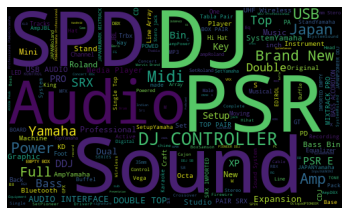

In [20]:
def showWordCloud(text):
    wordCloud = WordCloud(width=500, height=300, random_state=42, max_font_size=120).generate(text)
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.show()
    
allTitles = "".join(titles for titles in df["Title"][df.Product.isnull()])

showWordCloud(allTitles)


**Note:** After making this wordcloud, several products were added to the products list in the json files. This allowed to increase the number of product macthes from 43% to 68%

### Guessing the Brand

This website (https://www.americanmusical.com/BrandList.aspx) contains a broad list of companies that comercialize musical instruments. The list was copyied and pasted on a text file. Since it is a list of links, other elements were copied aswell, so the list needs to be cleaned fist.

In [21]:
# The following lines show the process followed to obtain the brand names from the txt

with open("resources/instrument_brands_list.txt") as file:
    data = file.read().replace("\n",",")

# The txt contains the brand and the number of items in source's web store
# The lines have a structure of the kind ItemName3 items(3)
# Let's use a regular expresion to remove those substrings

data = re.sub(r"([0-9])+ items?\([0-9]+\)","",data)

# store the brands in a list 
brandlist = data.split(",")

# Check the result
print(brandlist[:10])

# Write this into a JSON
brands = {"Brands":brandlist}
with open('resources/brands.json', 'w') as fp:
    json.dump(brands, fp)


['2BOX Drums', '512 Audio', 'Abasi Guitars', 'Ableton', 'Access', 'Acon Digital', 'Adam Audio', 'ADJ Lighting', 'Ahead', 'AirTurn']


In [22]:
# Now we define a function to check if the text contains a brand

def guessBrand(text):
    with open("resources/Brands.json") as file:
        data = json.load(file)
    brand = np.nan
    for name in data["Brands"]:
        if name.upper() in text.upper():
            return name.capitalize()
    return brand


df["Brand"] = df.apply(lambda row: guessBrand(row["Title"]), axis=1)

print(100 * int(df[["Brand"]].count()) /int(df[["Title"]].count())," % of the brands have been guessed from the title\n")
df[["Brand"]].info()

33.41747572815534  % of the brands have been guessed from the title

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5150 entries, 0 to 5166
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Brand   1721 non-null   object
dtypes: object(1)
memory usage: 80.5+ KB


In [23]:
df[df.Brand.notnull()][["Title", "Product", "Description", "Brand"]].head()

,Title,Product,Description,Brand
0,Yamaha (SY-77) Music Synthesizer,Synthesizer,Sri Lanka's Largest Digital Piano Seller Dire...,Yamaha
3,Yamaha Semi Acoustic Guitars,Guitar,Yamaha semi acoustic guitar. Model- FX310A. B...,Yamaha
4,Yamaha Guitar,Guitar,Yamaha fG-151 Made in Japan Good condition Goo...,Yamaha
11,"Fender 41"" box guitar",Guitar,Perfect sound and toneF cut model Brand new Is...,Fender
20,Yamaha PSR 433 Keyboard,Keyboard,Yamaha Organ in good condition with Hercules a...,Yamaha


In [24]:
df.Brand.unique()

array(['Yamaha', nan, 'Fender', 'Boss', 'Emg', 'Ibanez', 'Roland',
       'Numark', 'Tascam', 'Art', 'Zoom', 'Ams', 'Korg', 'Rme',
       'Behringer', 'Fishman', 'Jbl', 'Pioneer', 'Casio', 'Crown',
       'Shure', 'Marshall', 'Zildjian', 'Dbx', 'Sennheiser', 'Pearl',
       'Tama', 'Soundcraft', 'Epiphone', 'M-audio', 'Sabian', 'Rcf',
       'Gemini', 'Peavey', 'Access', 'Native instruments', 'Line ',
       'Mackie', 'Nord', 'Rode', 'Mapex', 'Sony', 'Alesis', 'Nux', 'Remo',
       'Akg', 'Takamine', 'Luna', 'Vox', 'Digitech', 'Cme', 'Jackson',
       "D'addario", 'Hohner', 'Bose', 'Medeli', 'Esp', 'Novation',
       'Lakland', 'Evans', 'Denon dj', 'Kawai', 'Washburn', 'Qsc',
       'Electro voice', 'Ampeg', 'Paiste', 'Warwick', 'Matrix', 'Audix',
       'Randall', 'Nektar', 'Apogee', 'Neutrik', 'Mxr', 'Reloop', 'Prs',
       'Skb', 'Focusrite', 'Gibson', 'Gator', 'Lexicon', 'Genelec',
       'Laney', 'Rane', 'Dunlop', 'Presonus', 'Tc helicon', 'Eminence',
       'Celestion', 'Steinber

In [25]:
df["Brand"].value_counts()

Yamaha        562
Roland        172
Jbl            86
Pioneer        76
Casio          64
             ... 
Lakland         1
Nord            1
Luna            1
Medeli          1
Pedaltrain      1
Name: Brand, Length: 96, dtype: int64

In [26]:
# We saved the processed data
df.to_csv("processed-data.csv")